In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image
import import_ipynb
import io
import fidelity

im = Image.open('house.tif')
f = np.array(im)

importing Jupyter notebook from fidelity.ipynb


In [2]:
dim1, dim2 = np.shape(f)
print(dim1, dim2)
gamma = 2.2
fl = 255*((f/255)**gamma)

# Creating Bayer Threshold Matrices
I1 = 0
I2 = np.block([[4*I1 + 1,4*I1 + 2],[4*I1 + 3,4*I1]])
I4 = np.block([[4*I2 + 1,4*I2 + 2],[4*I2 + 3,4*I2]])
I8 = np.block([[4*I4 + 1,4*I4 + 2],[4*I4 + 3,4*I4]])

print("I2 = ", I2)
print("I4 = ", I4)
print("I8 = ", I8)

256 384
[[1 2]
 [3 0]]
[[ 5  9  6 10]
 [13  1 14  2]
 [ 7 11  4  8]
 [15  3 12  0]]
[[21 37 25 41 22 38 26 42]
 [53  5 57  9 54  6 58 10]
 [29 45 17 33 30 46 18 34]
 [61 13 49  1 62 14 50  2]
 [23 39 27 43 20 36 24 40]
 [55  7 59 11 52  4 56  8]
 [31 47 19 35 28 44 16 32]
 [63 15 51  3 60 12 48  0]]


In [3]:
def dither(img, I):
    imgl = 255*(img/255)**2.2
    
    N = I.shape[0]
    T = 255*(I+0.5)/(N**2)
    
    dim1 = img.shape[0]
    dim2 = img.shape[1]
    dithered = np.zeros((dim1, dim2))
    
    for i in range(dim1):
        for j in range(dim2):
            if imgl[i,j] > T[i % N, j % N]:
                dithered[i,j] = 255
                
    return dithered

RMSE 2x2 =  97.66897219213996


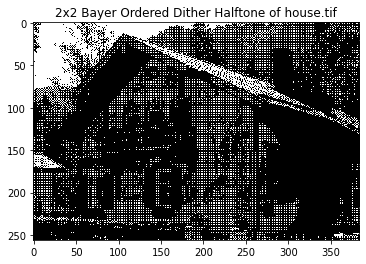

In [4]:
# 2x2 Bayer Dither
# N = 2
# I = I2
# T = 255*(I + 0.5)/(N**2)
# print("T = ", T)        

# b2 = np.zeros((dim1,dim2))
# for i in range(dim1):
#     for j in range(dim2):
#         if fl[i,j] > T[i%N, j%N]:
#             b2[i,j] = 255
#         else:
#             b2[i,j] = 0

b2 = dither(f, I2)
            
plt.figure()
plt.title("2x2 Bayer Ordered Dither Halftone of house.tif")
plt.imshow(b2,cmap=plt.cm.gray,interpolation='none')

img_out = Image.fromarray(b2.astype(np.uint8))
img_out.save("Bayer2x2.tif")

count = 0
for i in range(dim1):
    for j in range(dim2):
        count += (f[i,j] - b2[i,j])**2
        
RMSE22 = np.sqrt((1/(dim1*dim2))*count)
print("RMSE 2x2 = ", RMSE22)

RMSE 4x4 =  101.00692201569473


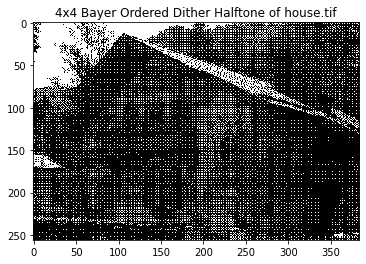

In [5]:
# 4x4 Bayer Dither
# N = 4
# I = I4
# T = 255*(I + 0.5)/(N**2)

# b4 = np.zeros((dim1,dim2))
# for i in range(dim1):
#     for j in range(dim2):
#         if fl[i,j] > T[i%N, j%N]:
#             b4[i,j] = 255
#         else:
#             b4[i,j] = 0

b4 = dither(f, I4)
            
plt.figure()
plt.title("4x4 Bayer Ordered Dither Halftone of house.tif")
plt.imshow(b4,cmap=plt.cm.gray,interpolation='none')

img_out = Image.fromarray(b4.astype(np.uint8))
img_out.save("Bayer4x4.tif")

count = 0
for i in range(dim1):
    for j in range(dim2):
        count += (f[i,j] - b4[i,j])**2
        
RMSE44 = np.sqrt((1/(dim1*dim2))*count)
print("RMSE 4x4 = ", RMSE44)

RMSE 8x8 =  100.91452962396079


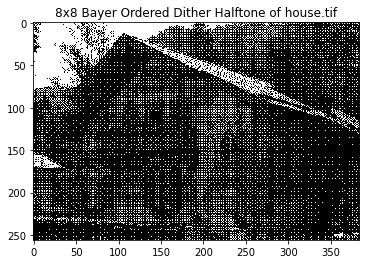

In [6]:
# 8x8 Bayer Dither
# N = 8
# I = I8
# T = 255*(I + 0.5)/(N**2)

# b8 = np.zeros((dim1,dim2))
# for i in range(dim1):
#     for j in range(dim2):
#         if fl[i,j] > T[i%N, j%N]:
#             b8[i,j] = 255
#         else:
#             b8[i,j] = 0

b8 = dither(f, I8)
            
plt.figure()
plt.title("8x8 Bayer Ordered Dither Halftone of house.tif")
plt.imshow(b8,cmap=plt.cm.gray,interpolation='none')

img_out = Image.fromarray(b8.astype(np.uint8))
img_out.save("Bayer8x8.tif")

count = 0
for i in range(dim1):
    for j in range(dim2):
        count += (f[i,j] - b8[i,j])**2
        
RMSE88 = np.sqrt((1/(dim1*dim2))*count)
print("RMSE 8x8 = ", RMSE88)

In [7]:
def fidelity(f, b):
    # calculate dimensions of input images
    dim1, dim2 = np.shape(f)
    
    # gamma correct input images
    gamma = 2.2
    fl = 255*(f/255)**gamma
    bl = 255*(b/255)**gamma
    
    # define 7x7 Gaussian filter   
    sigsq = 2
    size = 7
    h = np.zeros((size, size))
    for i in range(-3, 4):
        for j in range(-3, 4):
            h[i+3,j+3] = np.exp(-(i**2 + j**2)/(2*sigsq))
    sumh = np.sum(h)
    C = 1/sumh
    h = C*h
    
    # pad gamma un-corrected matrices and initialize new matrices
    fl = np.pad(fl,((3,3),(3,3)))
    bl = np.pad(bl,((3,3),(3,3)))
    flpf = np.zeros((dim1,dim2))
    blpf = np.zeros((dim1,dim2))
    
    # apply 7x7 Gaussian filter to each index
    for i in range(3, dim1+3):
        for j in range(3, dim2+3):
            flpf[i-3,j-3] = np.sum(np.multiply(fl[i-3:i+4, j-3:j+4], h))
            blpf[i-3,j-3] = np.sum(np.multiply(bl[i-3:i+4, j-3:j+4], h))
    
    # re-gamma correct
    ftil = 255*((flpf/255)**(1/3))
    btil = 255*((blpf/255)**(1/3))
    
    # calculate fidelity
    count = 0
    for i in range(dim1):
        for j in range(dim2):
            count += (ftil[i,j] - btil[i,j])**2
    fid = np.sqrt((1/(dim1*dim2))*count)
    
    return fid

In [8]:
# Calculating fidelities
fid2 = fidelity(f, b2)
fid4 = fidelity(f, b4)
fid8 = fidelity(f, b8)

print("fid2 = ", fid2)
print("fid4 = ", fid4)
print("fid8 = ", fid8)

fid2 =  50.05694796030135
fid4 =  16.558342510690416
fid8 =  14.691773433816458
